In [29]:
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

# Blurred, absolutized, objective function

Consider the optimization problem
$$\min_x \mathcal{J}(x) := \min_x \frac{1}{2}\|f(x) - d\|^2$$

In this notebook we consider the following blurred version of the optimization problem function:
$$\min_x \frac{1}{2}\|B \left( a\left(f(x)\right) - a(d)\right)\|^2$$
where 
 - $a(u)$ is a smooth approximation to the pointwise absolute value function
 - $B$ is a Gaussian blurring operator
 
Idea:
 - The goal of the blurring is to reduce oscillations in the objective function, and remove local minima
 - The reason for taking the absolute value function before blurring is that blurring an oscillatory function will make the function very small, destroying useful information.

# Gauss Pulse

Let $f(x)$ be the following gauss pulse:
$$f(x)(t) := \exp\left(-\frac{(t - x)^2}{s^2}\right) \exp\left(2 \pi i f (t - x)\right)$$
Here
 - $s=0.1$ is the width of the pulse
 - $f=1.5$ is the frequency
 - $x$ is the unknown center of the pulse, which we wish to determine by solving the optimization problem

Text(0, 0.5, 'f(x)(t)')

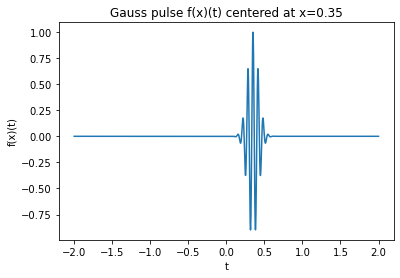

In [30]:
n=2000
tt = np.linspace(-2,2,n)

def make_gauss_pulse(center):
    c = center
    s = 0.1 # pulse width
    f = 1.5 / s # central frequency
    ff_complex = np.exp(-((tt-c)/s)**2) * np.exp(1j * 2. * np.pi * f * (tt-c))
    return ff_complex.real

c = 0.35
ff = make_gauss_pulse(c)
plt.plot(tt,ff)
plt.title('Gauss pulse f(x)(t) centered at x='+ str(c))
plt.xlabel('t')
plt.ylabel('f(x)(t)')

# Problem: $\mathcal{J}$ is highly oscillatory

Text(0, 0.5, 'J(x)')

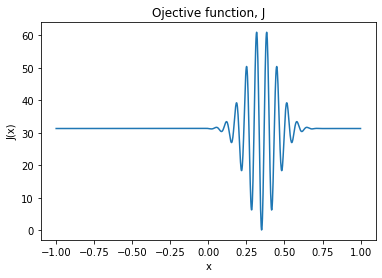

In [31]:
shifts = tt[np.bitwise_and(tt >= -1, tt < 1)]

def objective(shift):
    ff_predicted = make_gauss_pulse(shift)
    res = ff - ff_predicted
    J = 0.5 * np.dot(res, res)
    return J

ns = len(shifts)
JJ = np.zeros(ns)
for k in range(ns):
    JJ[k] = objective(shifts[k])

plt.figure()
plt.plot(shifts, JJ)
plt.title('Ojective function, J')
plt.xlabel('x')
plt.ylabel('J(x)')

# Smooth approximation to the absolute value function

Let $\rho$ be a constant, say, $\rho=1$, and define $a_\rho$ as the following approximation to the absolute value function:

$$a(u) := \left( u^2 + \rho^2 \right)^{1/2} - \rho \approx |u|$$

We shift $a$ so that $a(0) = 0$.

We show the absolutized Gauss pulse, $a(\phi_c(x))$.

Text(0, 0.5, 'a(f(x))(t)')

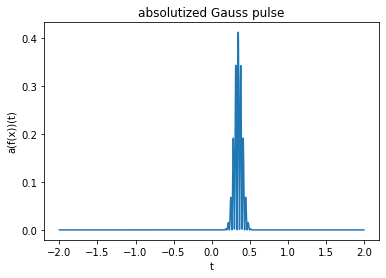

In [32]:
def absolutize(ff, rho=1e0):
    return np.sqrt(rho**2 + np.power(ff, 2)) - rho

ff2 = absolutize(ff)
plt.plot(tt,ff2)
plt.title('absolutized Gauss pulse')
plt.xlabel('t')
plt.ylabel('a(f(x))(t)')

# Gaussian blur kernel

Let 
$$g(t) := C \exp\left(-\frac{1}{2}\frac{t^2}{w^2}\right)$$
be the Gaussian kernel with width $w$ and normalization constant $C$.

Let $B_w$ be the associated Gaussian blurring kernel,
$$B_w u := g \ast u,$$
where $\ast$ denotes convolution.

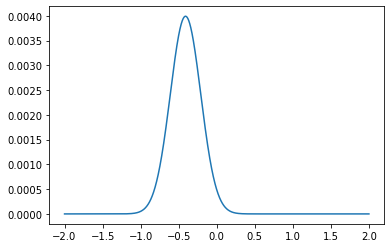

In [33]:
def make_gaussian(center, width):
    ff0 = np.exp(-0.5*((tt-center)/width)**2)
    return ff0 / np.sum(ff0)

gg = make_gaussian(-0.41, 0.2)
plt.plot(tt,gg)

Text(0.5, 1.0, 'blurred boxcar function')

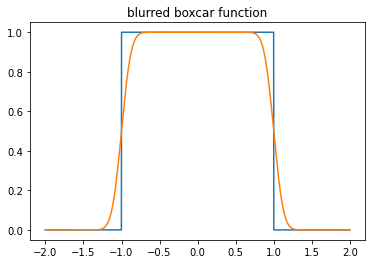

In [34]:
def make_gaussblur_matrix(width):
    B = np.zeros((n,n)) # Gaussblur matrix
    for k in range(n):
        B[k,:] = make_gaussian(tt[k], width)
    return B

B = make_gaussblur_matrix(0.1)

f = (tt >= -1.0) * (tt <= 1.0)

Bf = np.dot(B, f)
plt.plot(tt,f)
plt.plot(tt,Bf)
plt.title('blurred boxcar function')

We now apply a Gaussian blur to $f(0)$ and $a(f(0))$.
 - When we blur $f(x)$, it becomes tiny
 - When we blur $a(f(0))$, it remains large

# Blurred and absolutized versions of $f(0)$

Text(0.5, 1.0, 'B a(f(0))')

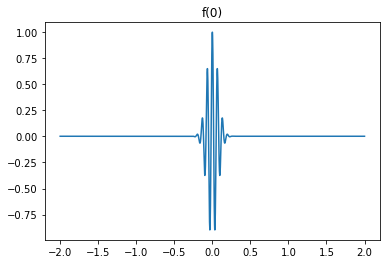

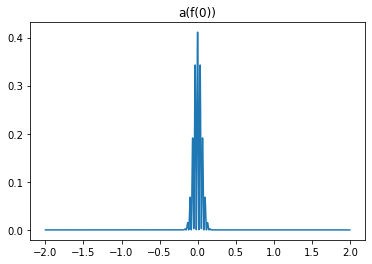

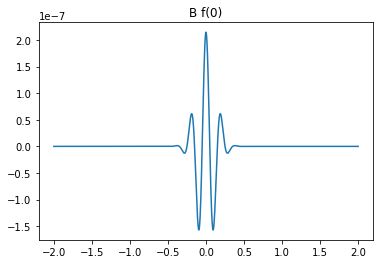

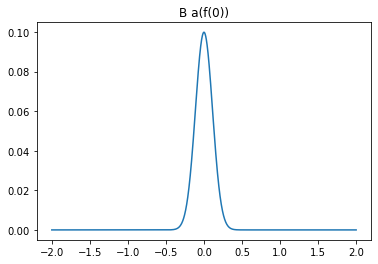

In [40]:
f = make_gauss_pulse(0)
af = absolutize(f)

Bf = np.dot(B, f)
Baf = np.dot(B, af)

plt.figure()
plt.plot(tt, f)
plt.title('f(0)')

plt.figure()
plt.plot(tt, af)
plt.title('a(f(0))')

plt.figure()
plt.plot(tt, Bf)
plt.title('B f(0)')

plt.figure()
plt.plot(tt, Baf)
plt.title('B a(f(0))')

# Blurred and absolutized versions of $\mathcal{J}$

Text(0.5, 1.0, 'J abs blur')

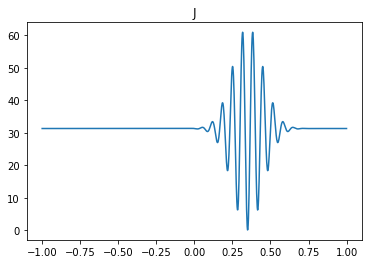

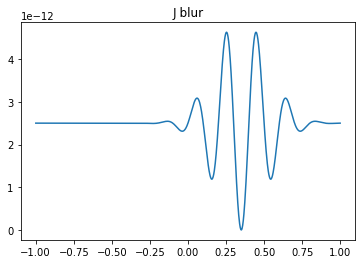

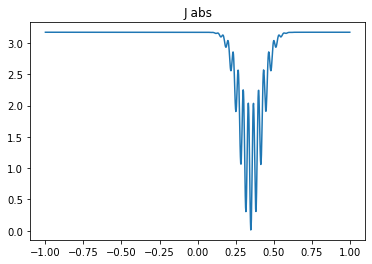

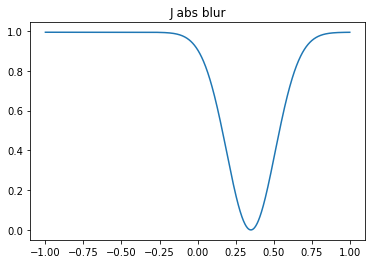

In [125]:
shifts = tt[np.bitwise_and(tt >= -1, tt < 1)]

blur_width = 0.2
B = make_gaussblur_matrix(blur_width)

def objective(shift):
    ff_predicted = make_gauss_pulse(shift)
    res = ff - ff_predicted
    J = 0.5 * np.dot(res, res)
    return J

def objective_blur(shift):
    ff_predicted = make_gauss_pulse(shift)
    res = ff - ff_predicted
    J = 0.5 * np.dot(res, np.dot(B, res))
    return J

def objective_abs(shift):
    ff_predicted = make_gauss_pulse(shift)
    res = absolutize(ff) - absolutize(ff_predicted)
    J = 0.5 * np.dot(res, res)
    return J

def objective_abs_blur(shift):
    ff_predicted = make_gauss_pulse(shift)
    res = absolutize(ff) - absolutize(ff_predicted)
    J = 0.5 * np.dot(res, np.dot(B, res))
    return J

ns = len(shifts)
JJ = np.zeros(ns)
JJ_blur = np.zeros(ns)
JJ_abs = np.zeros(ns)
JJ_abs_blur = np.zeros(ns)
for k in range(ns):
    JJ[k] = objective(shifts[k])
    JJ_blur[k] = objective_blur(shifts[k])
    JJ_abs[k] = objective_abs(shifts[k])
    JJ_abs_blur[k] = objective_abs_blur(shifts[k])

plt.figure()
plt.plot(shifts, JJ)
plt.title('J')

plt.figure()
plt.plot(shifts, JJ_blur)
plt.title('J blur')

plt.figure()
plt.plot(shifts, JJ_abs)
plt.title('J abs')

plt.figure()
plt.plot(shifts, JJ_abs_blur)
plt.title('J abs blur')

# Modified objective function with different levels of blurring

In [126]:
blur_widths = [0.001, 0.01, 0.1, 0.2]
all_JJ = []
for blur_width in blur_widths:
    B = make_gaussblur_matrix(blur_width)
    def objective_abs_blur(shift):
        ff_predicted = make_gauss_pulse(shift)
        res = absolutize(ff) - absolutize(ff_predicted)
        J = 0.5 * np.dot(res, np.dot(B, res))
        return J

    JJ = np.zeros(ns)
    for k in range(ns):
        JJ[k] = objective_abs_blur(shifts[k])
    all_JJ.append(JJ)

Text(0.5, 1.0, 'J abs blur with different blurring widths')

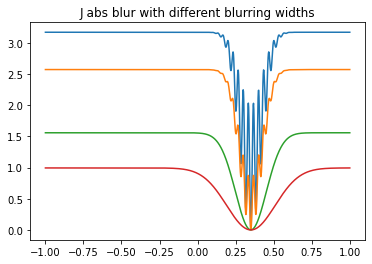

In [127]:
nb = len(blur_widths)

plt.figure()
for k in range(nb):
    plt.plot(shifts, all_JJ[k])
plt.title('J abs blur with different blurring widths')